Using device: cuda
Loading datasets...
Loaded CelebA dataset with 10000 samples
Loaded Binary dataset with 144000 samples
Loaded LCC FASD real dataset with 1302 samples
Loaded LCC FASD spoof dataset with 7444 samples
Loaded CASIA-SURF train dataset with 29266 samples as test dataset
Creating data loaders...

Dataset Statistics:
Training samples: 130196
Validation samples: 32550
Test samples: 29266

Showing sample images:
Training Set:


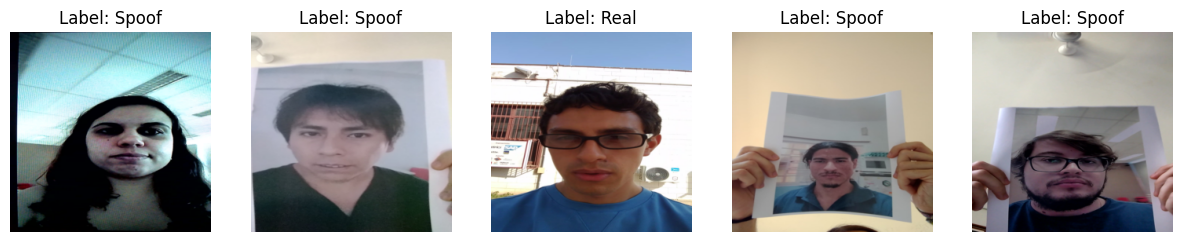

Validation Set:


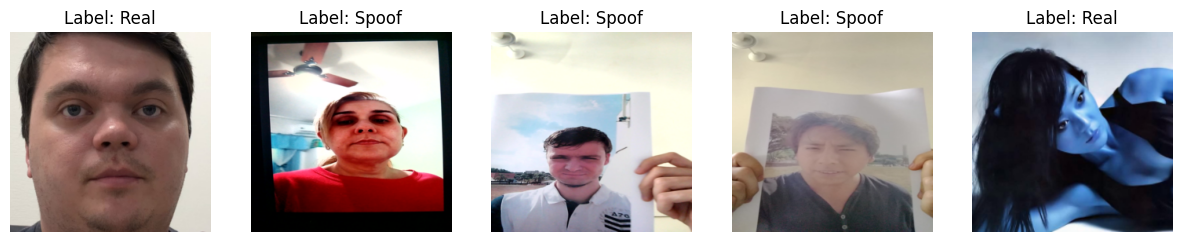

Test Set:


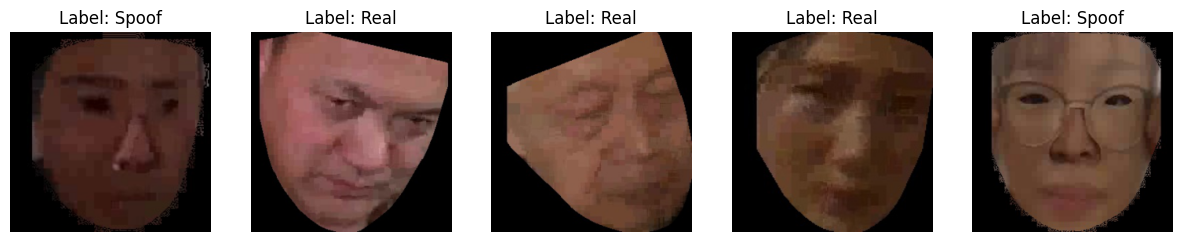

In [8]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image

# Define device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset Definitions

# Dataset One - CelebA Dataset from NPZ file
class CelebADataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data = np.load(data_path)
        self.X = self.data['arr_0']
        self.y = self.data['arr_1']
        self.transform = transform
        print(f"Loaded CelebA dataset with {len(self.y)} samples")

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]
        if self.transform:
            image = Image.fromarray(image)
            image = self.transform(image)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

# Dataset Two - Binary Dataset from Directories
class BinaryDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []

        for category in ["attack_cce", "attack_hp", "attack_print1", "attack_print2", "real"]:
            label = 0 if category.startswith("attack") else 1
            category_dir = os.path.join(root_dir, category)
            if os.path.exists(category_dir):
                for root, _, files in os.walk(category_dir):
                    for file in files:
                        if file.endswith((".jpg", ".png")):
                            self.data.append((os.path.join(root, file), label))
        
        print(f"Loaded Binary dataset with {len(self.data)} samples")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

# Dataset Three - LCC FASD Dataset
class SpoofDataset(Dataset):
    def __init__(self, root_dir, category, label, transform=None):
        self.root_dir = os.path.join(root_dir, category)
        self.transform = transform
        self.data = []
        self.label = label

        if os.path.exists(self.root_dir):
            for root, _, files in os.walk(self.root_dir):
                for file in files:
                    if file.endswith((".png", ".jpg")):
                        self.data.append(os.path.join(root, file))
        
        print(f"Loaded LCC FASD {category} dataset with {len(self.data)} samples")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(self.label, dtype=torch.long)

# Dataset Four - CASIA-SURF Dataset for Test
class CASIADataset(Dataset):
    def __init__(self, dataset_path, txt_file_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.samples = []

        # Read the txt file and collect paths for images along with their labels
        with open(txt_file_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 2:
                    color_path = parts[0]
                    label = int(parts[-1])
                    color_full_path = os.path.join(self.dataset_path, color_path)
                    if os.path.exists(color_full_path):
                        self.samples.append((color_full_path, label))

        print(f"Loaded CASIA-SURF train dataset with {len(self.samples)} samples as test dataset")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        color_path, label = self.samples[idx]
        image = Image.open(color_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

# Define the transforms
resize_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load all datasets
def load_all_datasets():
    # Load the CelebA dataset
    celebA_dataset = CelebADataset('anti_spoofing_data_224.npz', transform=resize_transform)

    # Load the Binary dataset
    binary_dataset = BinaryDataset(
        "/media/pria/New Volume/Spoofing/Datasets/2020-plosone-recod-mpad/",
        transform=resize_transform
    )

    # Load the LCC FASD dataset (real and spoof)
    lcc_fasd_real = SpoofDataset(
        root_dir="/media/pria/New Volume/Spoofing/Datasets/LCC_FASD_CASIA/lcc-fasd-casia/LCC_FASD/LCC_FASD_training",
        category="real",
        label=1,
        transform=resize_transform
    )
    lcc_fasd_spoof = SpoofDataset(
        root_dir="/media/pria/New Volume/Spoofing/Datasets/LCC_FASD_CASIA/lcc-fasd-casia/LCC_FASD/LCC_FASD_training",
        category="spoof",
        label=0,
        transform=resize_transform
    )

    # Load CASIA-SURF train dataset as the test dataset
    casia_dataset = CASIADataset(
        dataset_path="/media/pria/New Volume/Spoofing/Datasets/CASIA-SURF-Challenge/",
        txt_file_path="/media/pria/New Volume/Spoofing/Datasets/CASIA-SURF-Challenge/train_list.txt",
        transform=resize_transform
    )

    return celebA_dataset, binary_dataset, lcc_fasd_real, lcc_fasd_spoof, casia_dataset

def create_data_loaders(celebA_dataset, binary_dataset, lcc_fasd_real, lcc_fasd_spoof, casia_dataset):
    # Combine training datasets
    combined_train_dataset = ConcatDataset([celebA_dataset, binary_dataset, lcc_fasd_real, lcc_fasd_spoof])

    # Split into training and validation sets
    train_indices, val_indices = train_test_split(
        list(range(len(combined_train_dataset))),
        test_size=0.2,
        random_state=42
    )

    # Create subsets
    train_dataset = Subset(combined_train_dataset, train_indices)
    val_dataset = Subset(combined_train_dataset, val_indices)

    # Create DataLoaders with shuffle=True
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(casia_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader

# Displaying sample images
def show_images(dataloader, num_images=5):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    
    images = images[:num_images]
    labels = labels[:num_images]
    
    fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
    for idx, (img, label) in enumerate(zip(images, labels)):
        img = img.permute(1, 2, 0).cpu().numpy()
        axes[idx].imshow(img)
        axes[idx].set_title(f"Label: {'Real' if label.item() == 1 else 'Spoof'}")
        axes[idx].axis('off')
    plt.show()

# Load datasets and create data loaders
print("Loading datasets...")
celebA_dataset, binary_dataset, lcc_fasd_real, lcc_fasd_spoof, casia_dataset = load_all_datasets()

print("Creating data loaders...")
train_loader, val_loader, test_loader = create_data_loaders(
    celebA_dataset, binary_dataset, lcc_fasd_real, lcc_fasd_spoof, casia_dataset
)

# Show dataset statistics and sample images
print("\nDataset Statistics:")
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

# Display sample images
print("\nShowing sample images:")
print("Training Set:")
show_images(train_loader)
print("Validation Set:")
show_images(val_loader)
print("Test Set:")
show_images(test_loader)

In [9]:
train_loader

In [10]:
val_loader

In [11]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from einops import rearrange
import math
import warnings
from torch.nn.init import _calculate_fan_in_and_fan_out

def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    def norm_cdf(x):
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)
    with torch.no_grad():
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)
        tensor.uniform_(2 * l - 1, 2 * u - 1)
        tensor.erfinv_()
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)
        tensor.clamp_(min=a, max=b)
        return tensor


def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    # type: (Tensor, float, float, float, float) -> Tensor
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)


def variance_scaling_(tensor, scale=1.0, mode='fan_in', distribution='normal'):
    fan_in, fan_out = _calculate_fan_in_and_fan_out(tensor)
    if mode == 'fan_in':
        denom = fan_in
    elif mode == 'fan_out':
        denom = fan_out
    elif mode == 'fan_avg':
        denom = (fan_in + fan_out) / 2
    variance = scale / denom
    if distribution == "truncated_normal":
        trunc_normal_(tensor, std=math.sqrt(variance) / .87962566103423978)
    elif distribution == "normal":
        tensor.normal_(std=math.sqrt(variance))
    elif distribution == "uniform":
        bound = math.sqrt(3 * variance)
        tensor.uniform_(-bound, bound)
    else:
        raise ValueError(f"invalid distribution {distribution}")


def lecun_normal_(tensor):
    variance_scaling_(tensor, mode='fan_in', distribution='truncated_normal')


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, *args, **kwargs):
        x = self.norm(x)
        return self.fn(x, *args, **kwargs)


class GELU(nn.Module):
    def forward(self, x):
        return F.gelu(x)

def conv(in_channels, out_channels, kernel_size, bias=False, padding = 1, stride = 1):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2), bias=bias, stride=stride)


def shift_back(inputs,step=2):          # input [bs,28,256,310]  output [bs, 28, 256, 256]
    [bs, nC, row, col] = inputs.shape
    down_sample = 256//row
    step = float(step)/float(down_sample*down_sample)
    out_col = row
    for i in range(nC):
        inputs[:,i,:,:out_col] = \
            inputs[:,i,:,int(step*i):int(step*i)+out_col]
    return inputs[:, :, :, :out_col]

# class MS_MSA(nn.Module):
#     def __init__(
#             self,
#             dim,
#             dim_head,
#             heads,
#     ):
#         super().__init__()
#         self.num_heads = heads
#         self.dim_head = dim_head
#         self.to_q = nn.Linear(dim, dim_head * heads, bias=False)
#         self.to_k = nn.Linear(dim, dim_head * heads, bias=False)
#         self.to_v = nn.Linear(dim, dim_head * heads, bias=False)
#         self.rescale = nn.Parameter(torch.ones(heads, 1, 1))
#         self.proj = nn.Linear(dim_head * heads, dim, bias=True)
#         self.pos_emb = nn.Sequential(
#             nn.Conv2d(dim, dim, 3, 1, 1, bias=False, groups=dim),
#             GELU(),
#             nn.Conv2d(dim, dim, 3, 1, 1, bias=False, groups=dim),
#         )
#         self.dim = dim

#     def forward(self, x_in):
#         """
#         x_in: [b,h,w,c]
#         return out: [b,h,w,c]
#         """
#         b, h, w, c = x_in.shape
#         x = x_in.reshape(b,h*w,c)
#         q_inp = self.to_q(x)
#         k_inp = self.to_k(x)
#         v_inp = self.to_v(x)
#         q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.num_heads),
#                                 (q_inp, k_inp, v_inp))
#         v = v
#         # q: b,heads,hw,c
#         q = q.transpose(-2, -1)
#         k = k.transpose(-2, -1)
#         v = v.transpose(-2, -1)
#         q = F.normalize(q, dim=-1, p=2)
#         k = F.normalize(k, dim=-1, p=2)
#         attn = (k @ q.transpose(-2, -1))   # A = K^T*Q
#         attn = attn * self.rescale
#         attn = attn.softmax(dim=-1)
#         x = attn @ v   # b,heads,d,hw
#         x = x.permute(0, 3, 1, 2)    # Transpose
#         x = x.reshape(b, h * w, self.num_heads * self.dim_head)
#         out_c = self.proj(x).view(b, h, w, c)
#         out_p = self.pos_emb(v_inp.reshape(b,h,w,c).permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
#         out = out_c + out_p

#         return out

import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange

class MS_MSA(nn.Module):
    def __init__(self, dim, dim_head, heads):
        super().__init__()
        self.num_heads = heads
        self.dim_head = dim_head
        self.to_q = nn.Linear(dim, dim_head * heads, bias=False)
        self.to_k = nn.Linear(dim, dim_head * heads, bias=False)
        self.to_v = nn.Linear(dim, dim_head * heads, bias=False)
        self.rescale = nn.Parameter(torch.ones(heads, 1, 1))
        self.proj = nn.Linear(dim_head * heads, dim, bias=True)
        self.pos_emb = nn.Sequential(
            nn.Conv2d(dim, dim, 3, 1, 1, bias=False, groups=dim),
            nn.GELU(),
            nn.Conv2d(dim, dim, 3, 1, 1, bias=False, groups=dim),
        )
        self.dim = dim

    def forward(self, x_in):
        b, h, w, c = x_in.shape

        # Downsample using max pooling
        x_downsampled = F.max_pool2d(x_in.permute(0, 3, 1, 2), kernel_size=2, stride=2)
        x_downsampled = x_downsampled.permute(0, 2, 3, 1)  # back to [b, h', w', c]
        b, h_ds, w_ds, c = x_downsampled.shape

        # Flatten and perform attention as before
        x_flat = x_downsampled.reshape(b, h_ds * w_ds, c)
        q_inp = self.to_q(x_flat)
        k_inp = self.to_k(x_flat)
        v_inp = self.to_v(x_flat)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.num_heads), (q_inp, k_inp, v_inp))
        q = q.transpose(-2, -1)
        k = k.transpose(-2, -1)
        v = v.transpose(-2, -1)

        q = F.normalize(q, dim=-1, p=2)
        k = F.normalize(k, dim=-1, p=2)
        attn = (k @ q.transpose(-2, -1)) * self.rescale
        attn = attn.softmax(dim=-1)
        x = attn @ v  
        x = x.permute(0, 3, 1, 2)  # Transpose
        x = x.reshape(b, h_ds * w_ds, self.num_heads * self.dim_head)
        
        # Project back to the original dimensionality but still at downsampled resolution
        out_c = self.proj(x).view(b, h_ds, w_ds, c)

        # Apply positional embeddings at downsampled resolution
        out_p = self.pos_emb(x_downsampled.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)

        # Combine the content and positional embeddings
        out = out_c + out_p

        # Upsample to original resolution using bicubic interpolation after combining with positional encoding
        out = F.interpolate(out.permute(0, 3, 1, 2), size=(h, w), mode='bicubic', align_corners=False)
        out = out.permute(0, 2, 3, 1)  # back to [b, h, w, c]

        return out



class FeedForward(nn.Module):
    def __init__(self, dim, mult=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(dim, dim * mult, 1, 1, bias=False),
            GELU(),
            nn.Conv2d(dim * mult, dim * mult, 3, 1, 1, bias=False, groups=dim * mult),
            GELU(),
            nn.Conv2d(dim * mult, dim, 1, 1, bias=False),
        )

    def forward(self, x):
        """
        x: [b,h,w,c]
        return out: [b,h,w,c]
        """
        out = self.net(x.permute(0, 3, 1, 2))
        return out.permute(0, 2, 3, 1)

class MSAB(nn.Module):
    def __init__(
            self,
            dim,
            dim_head,
            heads,
            num_blocks,
    ):
        super().__init__()
        self.blocks = nn.ModuleList([])
        for _ in range(num_blocks):
            self.blocks.append(nn.ModuleList([
                MS_MSA(dim=dim, dim_head=dim_head, heads=heads),
                PreNorm(dim, FeedForward(dim=dim))
            ]))

    def forward(self, x):
        """
        x: [b,c,h,w]
        return out: [b,c,h,w]
        """
        x = x.permute(0, 2, 3, 1)
        for (attn, ff) in self.blocks:
            x = attn(x) + x
            x = ff(x) + x
        out = x.permute(0, 3, 1, 2)
        return out

class MST(nn.Module):
    def __init__(self, in_dim=31, out_dim=31, dim=31, stage=2, num_blocks=[2,4,4]):
        super(MST, self).__init__()
        self.dim = dim
        self.stage = stage

        # Input projection
        self.embedding = nn.Conv2d(in_dim, self.dim, 3, 1, 1, bias=False)

        # Encoder
        self.encoder_layers = nn.ModuleList([])
        dim_stage = dim
        for i in range(stage):
            self.encoder_layers.append(nn.ModuleList([
                MSAB(
                    dim=dim_stage, num_blocks=num_blocks[i], dim_head=dim, heads=dim_stage // dim),
                nn.Conv2d(dim_stage, dim_stage * 2, 4, 2, 1, bias=False),
            ]))
            dim_stage *= 2

        # Bottleneck
        self.bottleneck = MSAB(
            dim=dim_stage, dim_head=dim, heads=dim_stage // dim, num_blocks=num_blocks[-1])

        # Decoder
        self.decoder_layers = nn.ModuleList([])
        for i in range(stage):
            self.decoder_layers.append(nn.ModuleList([
                nn.ConvTranspose2d(dim_stage, dim_stage // 2, stride=2, kernel_size=2, padding=0, output_padding=0),
                nn.Conv2d(dim_stage, dim_stage // 2, 1, 1, bias=False),
                MSAB(
                    dim=dim_stage // 2, num_blocks=num_blocks[stage - 1 - i], dim_head=dim,
                    heads=(dim_stage // 2) // dim),
            ]))
            dim_stage //= 2

        # Output projection
        self.mapping = nn.Conv2d(self.dim, out_dim, 3, 1, 1, bias=False)

        #### activation function
        self.lrelu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        """
        x: [b,c,h,w]
        return out:[b,c,h,w]
        """

        # Embedding
        fea = self.embedding(x)

        # Encoder
        fea_encoder = []
        for (MSAB, FeaDownSample) in self.encoder_layers:
            fea = MSAB(fea)
            fea_encoder.append(fea)
            fea = FeaDownSample(fea)

        # Bottleneck
        fea = self.bottleneck(fea)

        # Decoder
        for i, (FeaUpSample, Fution, LeWinBlcok) in enumerate(self.decoder_layers):
            fea = FeaUpSample(fea)
            fea = Fution(torch.cat([fea, fea_encoder[self.stage-1-i]], dim=1))
            fea = LeWinBlcok(fea)

        # Mapping
        out = self.mapping(fea) + x

        return out

# class MST_Plus_Plus(nn.Module):
#     def __init__(self, in_channels=3, out_channels=31, n_feat=31, stage=3):
#         super(MST_Plus_Plus, self).__init__()
#         self.stage = stage
#         self.conv_in = nn.Conv2d(in_channels, n_feat, kernel_size=3, padding=(3 - 1) // 2,bias=False)
#         modules_body = [MST(dim=31, stage=2, num_blocks=[1,1,1]) for _ in range(stage)]
#         self.body = nn.Sequential(*modules_body)
#         self.conv_out = nn.Conv2d(n_feat, out_channels, kernel_size=3, padding=(3 - 1) // 2,bias=False)

#     def forward(self, x):
#         """
#         x: [b,c,h,w]
#         return out:[b,c,h,w]
#         """
#         b, c, h_inp, w_inp = x.shape
#         hb, wb = 8, 8
#         pad_h = (hb - h_inp % hb) % hb
#         pad_w = (wb - w_inp % wb) % wb
#         x = F.pad(x, [0, pad_w, 0, pad_h], mode='reflect')
#         x = self.conv_in(x)
#         h = self.body(x)
#         h = self.conv_out(h)
#         h += x
#         return h[:, :, :h_inp, :w_inp]
    
class trial25(nn.Module):
    def __init__(self, in_channels=3, out_channels=31, n_feat=31, stage=3):
        super(trial25, self).__init__()
        self.stage = stage
        self.conv_in = nn.Conv2d(in_channels, n_feat, kernel_size=3, padding=(3 - 1) // 2,bias=False)
        modules_body = [MST(dim=31, stage=2, num_blocks=[1,1,1]) for _ in range(stage)]
        self.body = nn.Sequential(*modules_body)
        self.conv_out = nn.Conv2d(n_feat, out_channels, kernel_size=3, padding=(3 - 1) // 2,bias=False)

    def forward(self, x):
        """
        x: [b,c,h,w]
        return out:[b,c,h,w]
        """
        b, c, h_inp, w_inp = x.shape
        hb, wb = 8, 8
        pad_h = (hb - h_inp % hb) % hb
        pad_w = (wb - w_inp % wb) % wb
        x = F.pad(x, [0, pad_w, 0, pad_h], mode='reflect')
        x = self.conv_in(x)
        h = self.body(x)
        h = self.conv_out(h)
        h += x
        return h[:, :, :h_inp, :w_inp]




In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
import os
import json


# Directory to save model and logs
save_path = '../models/trial92'
os.makedirs(save_path, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PipelineModel(nn.Module):
    def __init__(self, in_channels=3, hsi_channels=31, num_classes=1, pretrained_weights_path=None):
        super(PipelineModel, self).__init__()
        self.reconstruction = trial25(in_channels, hsi_channels)
        self.spectral_to_rgb = SpectralToRGB(hsi_channels, 3)
        self.classifier = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        
        # Load pretrained weights if provided
        if pretrained_weights_path is not None:
            self.load_pretrained_weights(pretrained_weights_path)
        
        # Freeze the reconstruction model
        for param in self.reconstruction.parameters():
            param.requires_grad = False
        
        # Replace the final fully connected layer with a new one with the desired output size
        num_ftrs = self.classifier.classifier[1].in_features
        self.classifier.classifier[1] = nn.Linear(num_ftrs, num_classes)

    def load_pretrained_weights(self, pretrained_weights_path):
        state_dict = torch.load(pretrained_weights_path, map_location=device)
        if 'state_dict' in state_dict:
            state_dict = state_dict['state_dict']
        model_state_dict = self.reconstruction.state_dict()
        filtered_state_dict = {k: v for k, v in state_dict.items() if k in model_state_dict}
        model_state_dict.update(filtered_state_dict)
        self.reconstruction.load_state_dict(model_state_dict)
        print(f"Loaded pretrained weights from {pretrained_weights_path}")

    def forward(self, x):
        with torch.no_grad():  # Ensure the reconstruction model is not updated
            x = self.reconstruction(x)
        x = self.spectral_to_rgb(x)
        x = self.classifier(x)
        return x

class SpectralToRGB(nn.Module):
    def __init__(self, in_channels, out_channels=3):
        super(SpectralToRGB, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.spectral_att = SpectralAttention(64)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(16, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.spectral_att(x)
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.conv4(x)
        return x

class SpectralAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpectralAttention, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_pool = F.avg_pool2d(x, (x.size(2), x.size(3)))
        channel_weights = self.sigmoid(self.conv1(avg_pool))
        x_att = x * channel_weights
        return x_att


# Usage
pretrained_weights_path = '../models/pretrained_models/mstpp_flexi.pth'
model = PipelineModel(pretrained_weights_path=pretrained_weights_path).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10 # Set as needed
best_val_accuracy = 0.0
train_log = []

# Training and Validation Loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device).float().view(-1, 1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        predictions = torch.round(torch.sigmoid(outputs))
        train_correct += (predictions == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)

    model.eval()
    valid_loss = 0.0
    valid_correct = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * images.size(0)
            predictions = torch.round(torch.sigmoid(outputs))
            valid_correct += (predictions == labels).sum().item()

            # Calculate true positives, true negatives, false positives, and false negatives
            for pred, label in zip(predictions, labels):
                if label == 1 and pred == 1:
                    true_positives += 1
                elif label == 1 and pred == 0:
                    false_negatives += 1
                elif label == 0 and pred == 1:
                    false_positives += 1
                else:
                    true_negatives += 1

    valid_loss /= len(val_loader.dataset)
    valid_accuracy = valid_correct / len(val_loader.dataset)

    # Save the model with the best validation accuracy
    if valid_accuracy > best_val_accuracy:
        best_val_accuracy = valid_accuracy
        torch.save(model.state_dict(), os.path.join(save_path, f'best_model.pth'))

    # Calculate APCER, BPCER, ACER, HTER, and EER
    try:
        apcer = false_positives / (false_positives + true_negatives)
        bpcer = false_negatives / (false_negatives + true_positives)
        acer = (apcer + bpcer) / 2
        hter = (false_positives + false_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
        eer = bpcer  # Assuming the threshold is set to achieve EER
    except ZeroDivisionError:
        apcer, bpcer, acer, hter, eer = 0, 0, 0, 0, 0

    epoch_log = {
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'valid_loss': valid_loss,
        'valid_accuracy': valid_accuracy,
        'apcer': apcer,
        'bpcer': bpcer,
        'acer': acer,
        'hter': hter,
        'eer': eer
    }
    train_log.append(epoch_log)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")
    print(f"APCER: {apcer:.4f}, BPCER: {bpcer:.4f}, ACER: {acer:.4f}, HTER: {hter:.4f}, EER: {eer:.4f}")

# Save the training log
with open(os.path.join(save_path, 'train_log.json'), 'w') as f:
    json.dump(train_log, f, indent=4)


/tmp/ipykernel_1658870/3154497126.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pretrained_weights_path, map_location=device)


Loaded pretrained weights from ../models/pretrained_models/mstpp_flexi.pth


Validation Epoch 1/10: 100%|██████████████| 1018/1018 [1:50:18<00:00,  6.50s/it]


Epoch 1/10
Train Loss: 0.0462, Train Accuracy: 0.9829
Valid Loss: 0.0195, Valid Accuracy: 0.9916
APCER: 0.0087, BPCER: 0.0075, ACER: 0.0081, HTER: 0.0084, EER: 0.0075


Validation Epoch 2/10: 100%|██████████████| 1018/1018 [1:39:21<00:00,  5.86s/it]


Epoch 2/10
Train Loss: 0.0195, Train Accuracy: 0.9932
Valid Loss: 0.0081, Valid Accuracy: 0.9972
APCER: 0.0006, BPCER: 0.0107, ACER: 0.0057, HTER: 0.0028, EER: 0.0107


Validation Epoch 3/10: 100%|██████████████| 1018/1018 [1:39:48<00:00,  5.88s/it]


Epoch 3/10
Train Loss: 0.0138, Train Accuracy: 0.9952
Valid Loss: 0.0129, Valid Accuracy: 0.9956
APCER: 0.0020, BPCER: 0.0127, ACER: 0.0074, HTER: 0.0044, EER: 0.0127


Validation Epoch 4/10: 100%|██████████████| 1018/1018 [1:15:24<00:00,  4.44s/it]


Epoch 4/10
Train Loss: 0.0110, Train Accuracy: 0.9962
Valid Loss: 0.0068, Valid Accuracy: 0.9972
APCER: 0.0028, BPCER: 0.0030, ACER: 0.0029, HTER: 0.0028, EER: 0.0030


Validation Epoch 5/10: 100%|██████████████| 1018/1018 [1:00:40<00:00,  3.58s/it]


Epoch 5/10
Train Loss: 0.0084, Train Accuracy: 0.9972
Valid Loss: 0.0090, Valid Accuracy: 0.9970
APCER: 0.0009, BPCER: 0.0105, ACER: 0.0057, HTER: 0.0030, EER: 0.0105


Validation Epoch 6/10: 100%|██████████████| 1018/1018 [1:00:33<00:00,  3.57s/it]


Epoch 6/10
Train Loss: 0.0079, Train Accuracy: 0.9972
Valid Loss: 0.0046, Valid Accuracy: 0.9986
APCER: 0.0005, BPCER: 0.0049, ACER: 0.0027, HTER: 0.0014, EER: 0.0049


Validation Epoch 7/10: 100%|██████████████| 1018/1018 [1:00:34<00:00,  3.57s/it]


Epoch 7/10
Train Loss: 0.0069, Train Accuracy: 0.9977
Valid Loss: 0.0053, Valid Accuracy: 0.9982
APCER: 0.0016, BPCER: 0.0025, ACER: 0.0021, HTER: 0.0018, EER: 0.0025


Validation Epoch 8/10: 100%|██████████████| 1018/1018 [1:00:54<00:00,  3.59s/it]


Epoch 8/10
Train Loss: 0.0062, Train Accuracy: 0.9979
Valid Loss: 0.0043, Valid Accuracy: 0.9989
APCER: 0.0007, BPCER: 0.0028, ACER: 0.0017, HTER: 0.0011, EER: 0.0028


Validation Epoch 9/10: 100%|██████████████| 1018/1018 [1:22:19<00:00,  4.85s/it]


Epoch 9/10
Train Loss: 0.0058, Train Accuracy: 0.9981
Valid Loss: 0.0069, Valid Accuracy: 0.9980
APCER: 0.0003, BPCER: 0.0081, ACER: 0.0042, HTER: 0.0020, EER: 0.0081


Validation Epoch 10/10:  97%|█████████████▌| 987/1018 [1:20:08<02:31,  4.90s/it]

## Evalution

## Train set evalution

In [ ]:
import torch
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Directory where the model is saved
save_path = '../models/trial92'
model_save_path = os.path.join(save_path, 'best_model.pth')

# Instantiate the model
model = PipelineModel().to(device)

# Load the best model weights
model.load_state_dict(torch.load(model_save_path, map_location=device))

# Set the model to evaluation mode
model.eval()

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Function to evaluate loader and visualize predictions
def evaluate_loader(loader, loader_name="Dataset", num_images_to_show=5):
    correct = 0
    total = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    eval_loss = 0.0

    all_preds = []
    all_labels = []
    
    images_to_visualize = []
    pred_labels_to_visualize = []
    gt_labels_to_visualize = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc=f"Evaluating {loader_name}"):
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)  # Ensure labels are [batch_size, 1]
            outputs = model(images)
            loss = criterion(outputs, labels)
            eval_loss += loss.item() * images.size(0)

            predictions = torch.round(torch.sigmoid(outputs))
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            # Store predictions and labels for confusion matrix
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Visualize some images
            if len(images_to_visualize) < num_images_to_show:
                images_to_visualize.extend(images.cpu()[:num_images_to_show - len(images_to_visualize)])
                pred_labels_to_visualize.extend(predictions.cpu()[:num_images_to_show - len(pred_labels_to_visualize)])
                gt_labels_to_visualize.extend(labels.cpu()[:num_images_to_show - len(gt_labels_to_visualize)])

            # Calculate true positives, true negatives, false positives, and false negatives
            for pred, label in zip(predictions, labels):
                if label == 1 and pred == 1:
                    true_positives += 1
                elif label == 1 and pred == 0:
                    false_negatives += 1
                elif label == 0 and pred == 1:
                    false_positives += 1
                else:
                    true_negatives += 1

    # Calculate metrics
    eval_loss /= total
    accuracy = correct / total

    # Calculate APCER, BPCER, ACER, HTER, and EER
    try:
        apcer = false_positives / (false_positives + true_negatives)
        bpcer = false_negatives / (false_negatives + true_positives)
        acer = (apcer + bpcer) / 2
        hter = (false_positives + false_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
        eer = bpcer  # Assuming the threshold is set to achieve EER
    except ZeroDivisionError:
        apcer, bpcer, acer, hter, eer = 0, 0, 0, 0, 0

    # Print out the results for the current loader
    print(f"\nResults for {loader_name}:")
    print(f"Loss: {eval_loss:.4f}, Accuracy: {accuracy:.4f}")
    print(f"APCER: {apcer:.4f}, BPCER: {bpcer:.4f}, ACER: {acer:.4f}, HTER: {hter:.4f}, EER: {eer:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Attack', 'Real']))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)
    plot_confusion_matrix(cm, class_names=['Attack', 'Real'])

    # Visualize a few images with predictions
    print("\nVisualizing predictions (Predicted vs Ground Truth):")
    fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 15))
    for idx, (img, pred_label, gt_label) in enumerate(zip(images_to_visualize, pred_labels_to_visualize, gt_labels_to_visualize)):
        img = img.permute(1, 2, 0).cpu().numpy()  # Change from (C, H, W) to (H, W, C) for plotting
        axes[idx].imshow(img)
        axes[idx].set_title(f"Pred: {int(pred_label.item())} | GT: {int(gt_label.item())}")
        axes[idx].axis('off')
    plt.show()

# Evaluate on all three loaders (training, validation, and test)

# 1. Evaluate on train_loader (Real vs Spoof for training set)
evaluate_loader(train_loader, loader_name="Training Set", num_images_to_show=5)



## val set eval

In [ ]:
# 2. Evaluate on val_loader (Real vs Spoof for validation set)
evaluate_loader(val_loader, loader_name="Validation Set", num_images_to_show=5)




## Test set Eval (Cross dataset)

In [ ]:
# 3. Evaluate on test_loader (Real vs Spoof for test set)
evaluate_loader(test_loader, loader_name="Test Set", num_images_to_show=5)